# Experiment One
All available training data

## Augmentation of dataset

In [25]:
EXP_NUM=4

In [26]:
import tensorflow as tf
from pathlib import Path


def augment_in_place_orig_plus_4_no_resize(
    root: str | Path,
    *,
    allowed_ext: tuple[str, ...] = (".jpg", ".jpeg", ".png", ".webp", ".bmp", ".tif", ".tiff"),
    jpeg_quality: int = 95,
    suffix_sep: str = "__",
) -> dict[str, int]:
    """
    Dla każdego obrazu w root/<class_name>/:
      - NIE zmienia wymiarów obrazu
      - NIE usuwa oryginału
      - dodaje 4 nowe obrazy w tym samym folderze:
        flip, rot90, bright, contrast

    Zwraca: dict {class_name: liczba_dodanych_obrazów}
    """
    root = Path(root)
    allowed = {e.lower() for e in allowed_ext}
    stats: dict[str, int] = {}

    def load_image(path: Path) -> tf.Tensor:
        b = tf.io.read_file(str(path))
        # decode_image zachowuje oryginalny rozmiar
        img = tf.image.decode_image(b, channels=3, expand_animations=False)
        img = tf.cast(tf.clip_by_value(img, 0, 255), tf.uint8)
        return img

    def save_jpeg(img_uint8: tf.Tensor, out_path: Path):
        jpeg = tf.io.encode_jpeg(img_uint8, quality=jpeg_quality)
        tf.io.write_file(str(out_path), jpeg)

    # 4 augmentacje zachowujące rozmiar
    def aug_flip(img):      return tf.image.flip_left_right(img)
    def aug_rot90(img):     return tf.image.rot90(img, k=1)   # 90°
    def aug_bright(img):
        x = tf.image.adjust_brightness(tf.cast(img, tf.float32), 0.15 * 255.0)
        return tf.cast(tf.clip_by_value(x, 0, 255), tf.uint8)
    def aug_contrast(img):
        x = tf.image.adjust_contrast(tf.cast(img, tf.float32), 1.2)
        return tf.cast(tf.clip_by_value(x, 0, 255), tf.uint8)

    variants = [
        ("flip", aug_flip),
        ("rot90", aug_rot90),
        ("bright", aug_bright),
        ("contrast", aug_contrast),
    ]

    for class_dir in [p for p in root.iterdir() if p.is_dir()]:
        class_name = class_dir.name

        originals = [
            p for p in class_dir.iterdir()
            if p.is_file()
            and p.suffix.lower() in allowed
            and suffix_sep not in p.stem
        ]

        added = 0
        for p in originals:
            img = load_image(p)

            for tag, fn in variants:
                out_path = class_dir / f"{p.stem}{suffix_sep}{tag}.jpg"
                if out_path.exists():
                    continue
                save_jpeg(fn(img), out_path)
                added += 1

        stats[class_name] = added

    return stats


In [27]:
stats = augment_in_place_orig_plus_4_no_resize(
    root=f"data/E{EXP_NUM}/train",
)

print(stats)


{'black_morel': 68, 'bitter_bolete': 68, 'curry_milkcap': 68, 'destroying_angel': 68, 'brown_birch_bolete': 68}


## Importing datasets

In [28]:
import tensorflow as tf
from pathlib import Path
import os

TRAIN_DIR = f"data/E{EXP_NUM}/train"
TEST_DIR = "data/test"

IMG_SIZE = (512, 512)
BATCH_SIZE = 8
SEED = 42

# 4 augmentacje (takie same dla AlexNet i ResNet50)
AUG_SUFFIX_SEP = "__"
AUG_TAGS = ["flip", "rot90", "bright", "contrast"]

def _list_augmented_files(root: str | Path, tag: str, allowed_ext=(".jpg",".jpeg",".png",".webp",".bmp",".tif",".tiff")):
    root = Path(root)
    allowed = {e.lower() for e in allowed_ext}
    files, labels = [], []
    class_names = sorted([p.name for p in root.iterdir() if p.is_dir()])
    class_to_idx = {c:i for i,c in enumerate(class_names)}
    for c in class_names:
        class_dir = root / c
        for p in class_dir.iterdir():
            if not p.is_file():
                continue
            if p.suffix.lower() not in allowed:
                continue
            # tylko dane zaugmentowane daną augmentacją (bez oryginałów i bez innych augmentacji)
            if f"{AUG_SUFFIX_SEP}{tag}" not in p.stem:
                continue
            files.append(str(p))
            labels.append(class_to_idx[c])
    return files, labels, class_names

def _decode_and_resize(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, IMG_SIZE, method="bilinear")
    img = tf.cast(img, tf.float32)
    return img, label

def make_train_ds_for_aug(tag: str, shuffle=True):
    files, labels, class_names = _list_augmented_files(TRAIN_DIR, tag)
    if len(files) == 0:
        raise ValueError(f"Brak plików treningowych dla augmentacji '{tag}'. Upewnij się, że augmentacje zostały wygenerowane w {TRAIN_DIR}.")
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(files), 2048), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(_decode_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds, class_names

# Test (bez augmentacji)
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    label_mode="int"
).prefetch(tf.data.AUTOTUNE)

print("Ustawienia:")
print(" IMG_SIZE   =", IMG_SIZE)
print(" BATCH_SIZE =", BATCH_SIZE)
print(" AUG_TAGS   =", AUG_TAGS)


Found 20 files belonging to 5 classes.
Ustawienia:
 IMG_SIZE   = (512, 512)
 BATCH_SIZE = 8
 AUG_TAGS   = ['flip', 'rot90', 'bright', 'contrast']


## AlexNet512

In [29]:
import tensorflow as tf

def lrn(x, depth_radius=2, bias=1.0, alpha=1e-4, beta=0.75):
    return tf.nn.local_response_normalization(
        x, depth_radius=depth_radius, bias=bias, alpha=alpha, beta=beta
    )

def build_alexnet_512(input_shape=(512, 512, 3), num_classes=5, dropout=0.2):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Rescaling(1./255)(inputs)

    # Conv1
    x = tf.keras.layers.Conv2D(96, 11, strides=4, padding="valid", activation="relu")(x)
    x = tf.keras.layers.Lambda(lrn)(x)
    x = tf.keras.layers.MaxPooling2D(3, strides=2)(x)

    # Conv2
    x = tf.keras.layers.Conv2D(256, 5, padding="same", activation="relu")(x)
    x = tf.keras.layers.Lambda(lrn)(x)
    x = tf.keras.layers.MaxPooling2D(3, strides=2)(x)

    # Conv3-5
    x = tf.keras.layers.Conv2D(384, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2D(384, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(3, strides=2)(x)

    # Zamiast Flatten (żeby 512x512 nie zabiło parametrów)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # FC (AlexNet-like)
    x = tf.keras.layers.Dense(4096, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Dense(4096, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)

    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs, name="alexnet_512")


## Residual Network (ResNet50)

In [30]:
import tensorflow as tf

def build_resnet50_512(num_classes: int, input_shape=(512, 512, 3), train_base: bool = False):
    inputs = tf.keras.Input(shape=input_shape)

    # ResNet50 oczekuje preprocess_input
    x = tf.keras.applications.resnet50.preprocess_input(inputs)

    base = tf.keras.applications.ResNet50(
        include_top=False,
        weights="imagenet",
        input_tensor=x,
        pooling=None
    )
    base.trainable = train_base  # False = zamrożony backbone

    x = base.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs, name="resnet50_512")
    return model




## Trening 8 modeli (AlexNet i ResNet50 × 4 augmentacje)

- Uczymy łącznie **8 modeli**: 4×AlexNet512 i 4×ResNet50.
- Dla obu architektur używamy **tych samych 4 augmentacji**: `flip`, `rot90`, `bright`, `contrast`.
- **Modele uczą się wyłącznie na danych zaugmentowanych** (oryginały są pomijane w `train_ds`).
- Zbiór testowy pozostaje bez augmentacji.



=== Trenowanie: alexnet | augmentacja: flip | klasy: 5 ===
Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 333ms/step - loss: 1.6109 - sparse_categorical_accuracy: 0.1635
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.6086 - sparse_categorical_accuracy: 0.1386
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.6116 - sparse_categorical_accuracy: 0.1655
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.6106 - sparse_categorical_accuracy: 0.1186
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.6050 - sparse_categorical_accuracy: 0.3349
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 1.5991 - sparse_categorical_accuracy: 0.3954
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.5879 - sparse_categorical_accuracy: 0.4342
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.5605 - sparse_categorical_accuracy: 0.3772
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.4628 - sparse_categorical_accuracy: 0

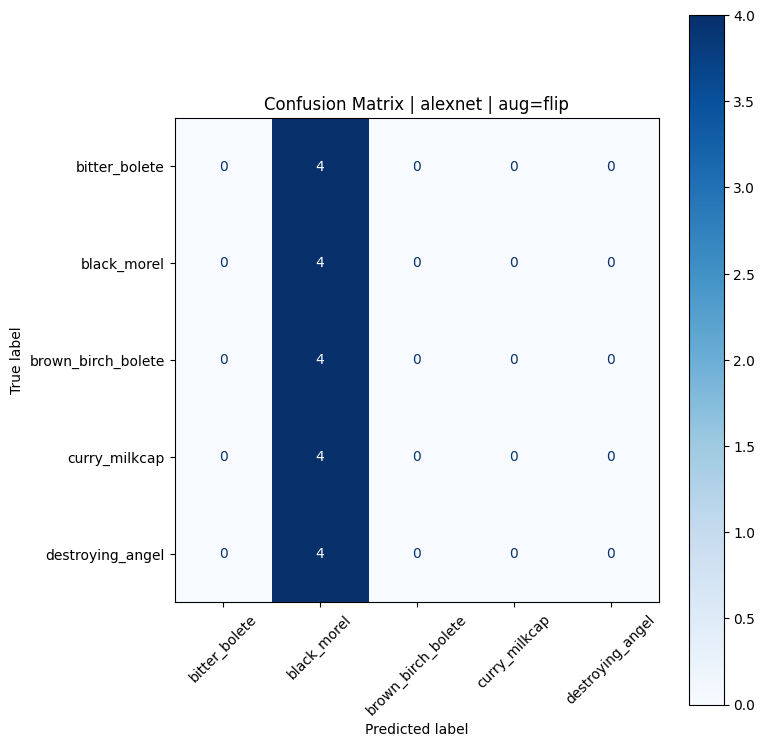


=== Trenowanie: alexnet | augmentacja: rot90 | klasy: 5 ===
Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 333ms/step - loss: 1.6102 - sparse_categorical_accuracy: 0.1850
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.6076 - sparse_categorical_accuracy: 0.1806
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.6111 - sparse_categorical_accuracy: 0.1435
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.6115 - sparse_categorical_accuracy: 0.1166
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.6065 - sparse_categorical_accuracy: 0.2653
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.6029 - sparse_categorical_accuracy: 0.3362
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 1.5960 - sparse_categorical_accuracy: 0.3319
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 1.5805 - sparse_categorical_accuracy: 0.3109
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.5244 - sparse_categorical_accuracy: 

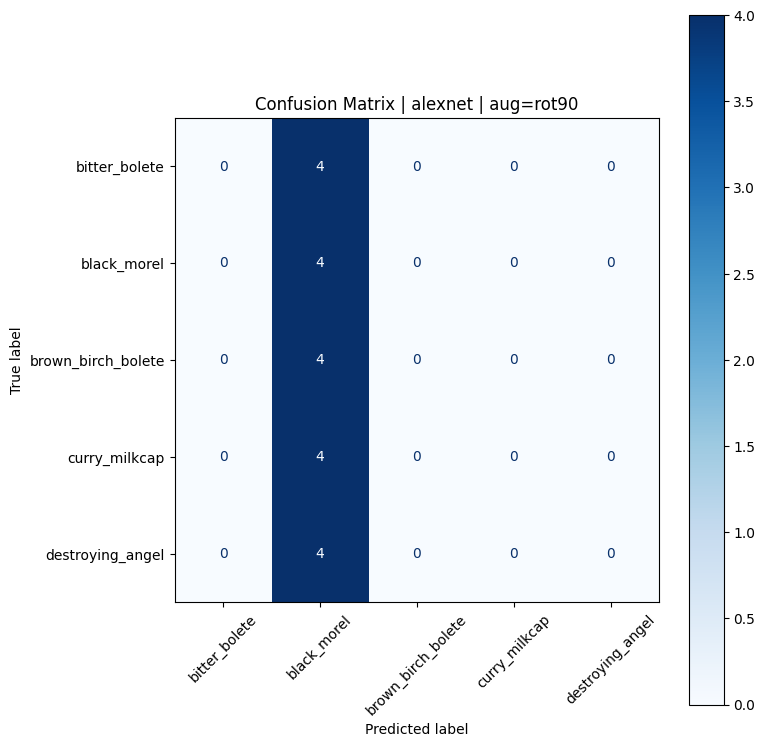


=== Trenowanie: alexnet | augmentacja: bright | klasy: 5 ===
Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 337ms/step - loss: 1.6124 - sparse_categorical_accuracy: 0.1041
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.6087 - sparse_categorical_accuracy: 0.1493
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.6100 - sparse_categorical_accuracy: 0.2084
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.6116 - sparse_categorical_accuracy: 0.1387
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.6068 - sparse_categorical_accuracy: 0.2973
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.6030 - sparse_categorical_accuracy: 0.2642
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.5988 - sparse_categorical_accuracy: 0.2573
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.5801 - sparse_categorical_accuracy: 0.2935
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 1.5348 - sparse_categorical_accuracy:

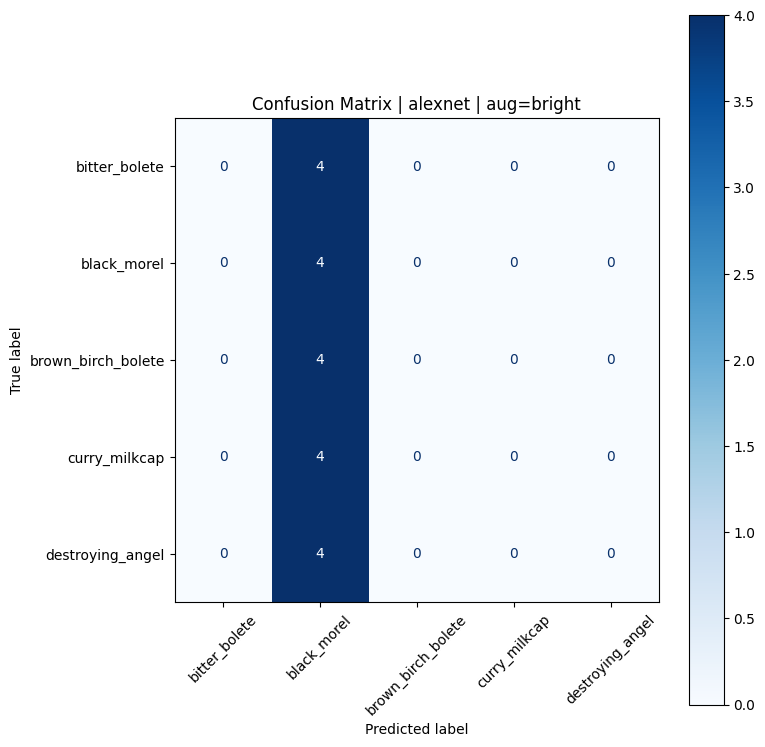


=== Trenowanie: alexnet | augmentacja: contrast | klasy: 5 ===
Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 337ms/step - loss: 1.6112 - sparse_categorical_accuracy: 0.0649
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.6082 - sparse_categorical_accuracy: 0.1640
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.6089 - sparse_categorical_accuracy: 0.2084
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.6088 - sparse_categorical_accuracy: 0.1289
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.6002 - sparse_categorical_accuracy: 0.2191
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.5888 - sparse_categorical_accuracy: 0.2107
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 1.5614 - sparse_categorical_accuracy: 0.3488
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 1.4414 - sparse_categorical_accuracy: 0.3698
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 1.7302 - sparse_categorical_accura

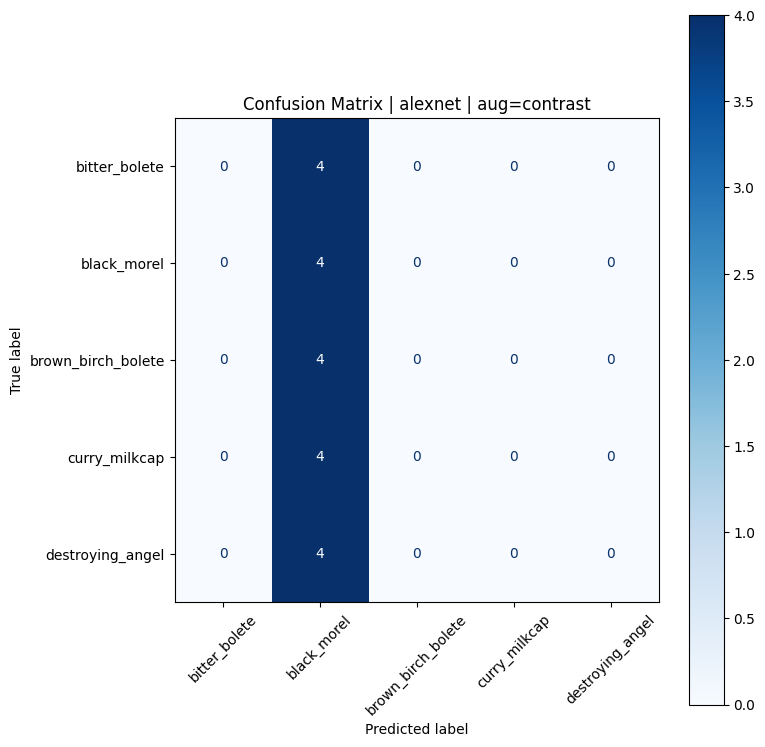


=== Trenowanie: resnet50 | augmentacja: flip | klasy: 5 ===
Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 421ms/step - loss: 1.8230 - sparse_categorical_accuracy: 0.2571
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 1.2087 - sparse_categorical_accuracy: 0.5479
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.8152 - sparse_categorical_accuracy: 0.7889
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.4979 - sparse_categorical_accuracy: 0.9339
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.4174 - sparse_categorical_accuracy: 0.8797
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.4181 - sparse_categorical_accuracy: 0.9383
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.3069 - sparse_categorical_accuracy: 0.9321
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.3032 - sparse_categorical_accuracy: 0.9254
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.2420 - sparse_categorical_accuracy: 0.948

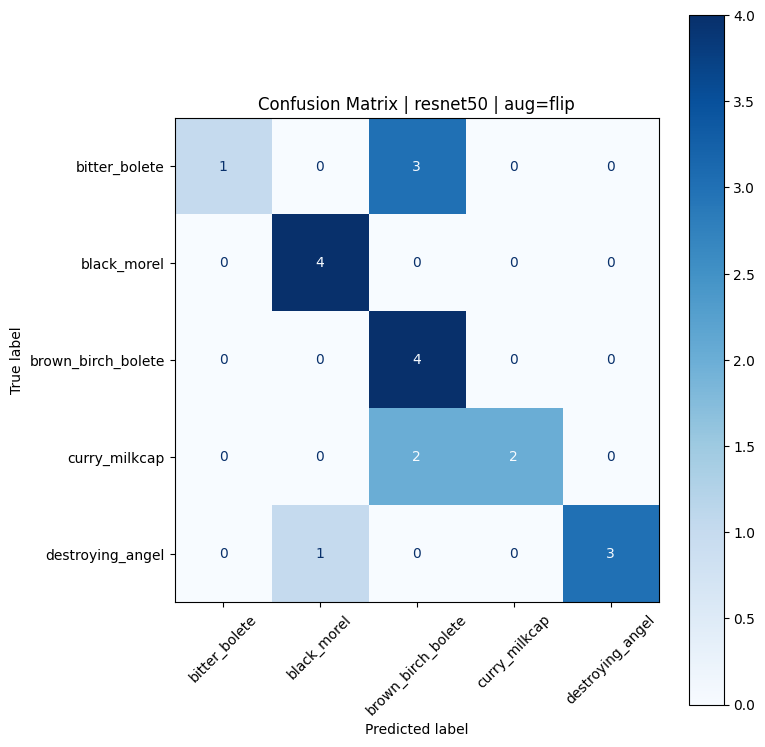


=== Trenowanie: resnet50 | augmentacja: rot90 | klasy: 5 ===
Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 421ms/step - loss: 1.7460 - sparse_categorical_accuracy: 0.3282
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 1.0881 - sparse_categorical_accuracy: 0.6128
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.8024 - sparse_categorical_accuracy: 0.7669
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.5696 - sparse_categorical_accuracy: 0.8458
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.4817 - sparse_categorical_accuracy: 0.8969
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.3414 - sparse_categorical_accuracy: 0.9169
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.2815 - sparse_categorical_accuracy: 0.9060
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.3128 - sparse_categorical_accuracy: 0.9779
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.2736 - sparse_categorical_accuracy: 0.

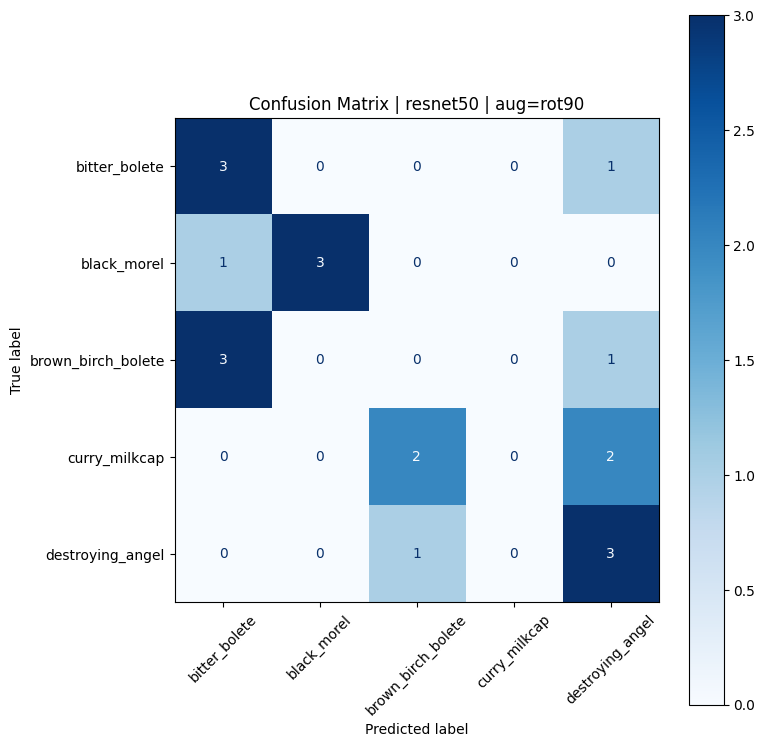


=== Trenowanie: resnet50 | augmentacja: bright | klasy: 5 ===
Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 464ms/step - loss: 1.9275 - sparse_categorical_accuracy: 0.2120
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 1.2717 - sparse_categorical_accuracy: 0.4392
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.7235 - sparse_categorical_accuracy: 0.8283
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.5456 - sparse_categorical_accuracy: 0.8671
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.4468 - sparse_categorical_accuracy: 0.8831
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.3701 - sparse_categorical_accuracy: 0.9274
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.2510 - sparse_categorical_accuracy: 0.9866
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.3107 - sparse_categorical_accuracy: 0.9312
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.1991 - sparse_categorical_accuracy: 0.982

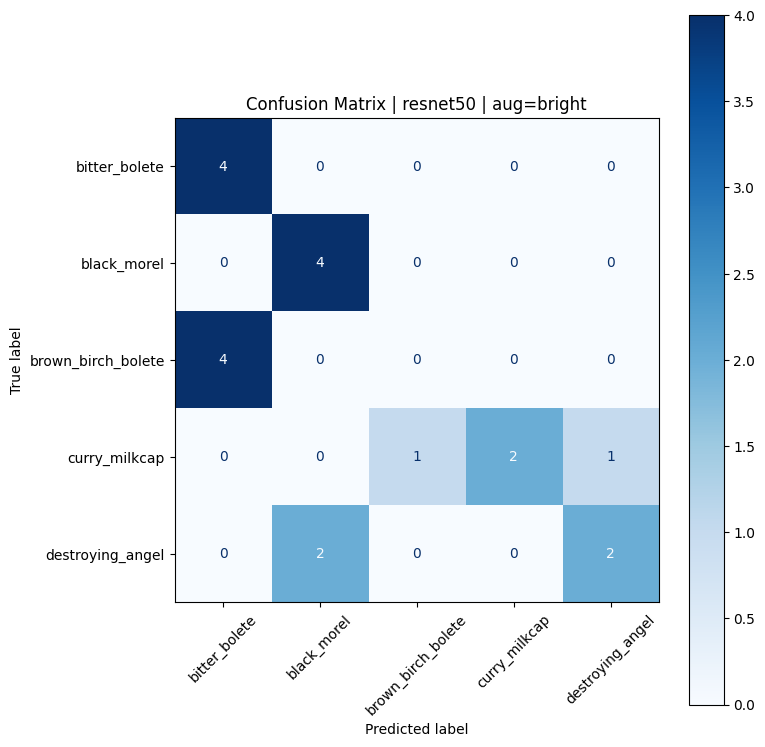


=== Trenowanie: resnet50 | augmentacja: contrast | klasy: 5 ===
Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 417ms/step - loss: 1.6929 - sparse_categorical_accuracy: 0.3224
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 1.0586 - sparse_categorical_accuracy: 0.5799
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.7300 - sparse_categorical_accuracy: 0.7611
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.5161 - sparse_categorical_accuracy: 0.8254
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.4082 - sparse_categorical_accuracy: 0.9580
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.3711 - sparse_categorical_accuracy: 0.9451
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.2708 - sparse_categorical_accuracy: 0.9852
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.2444 - sparse_categorical_accuracy: 0.9621
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.2257 - sparse_categorical_accuracy: 

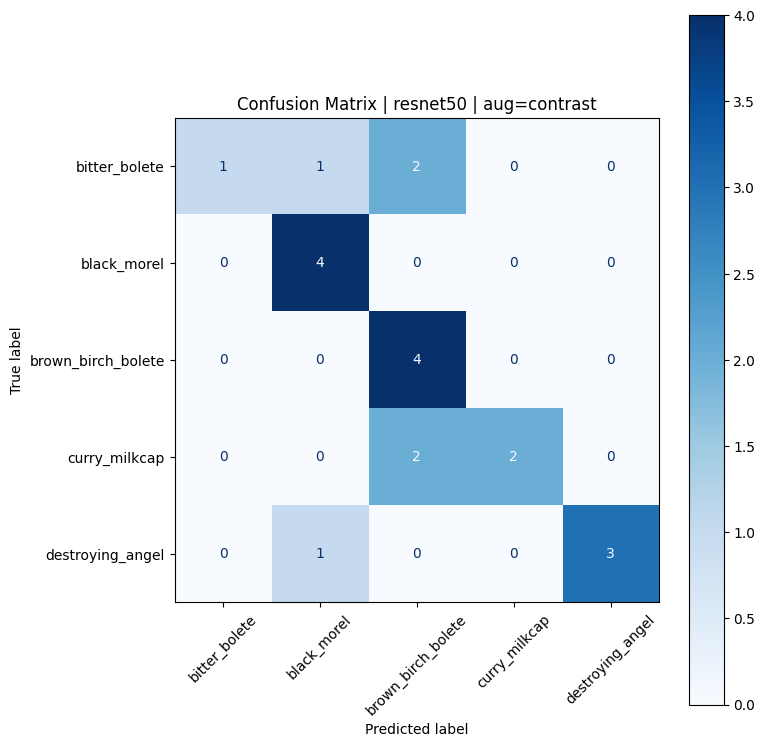

,model,augmentation,epochs,test_acc,test_loss,weights_path
2,alexnet,bright,100,0.20,1.610024,models/e4_alexnet_bright.weights.h5
3,alexnet,contrast,100,0.20,1.610120,models/e4_alexnet_contrast.weights.h5
0,alexnet,flip,100,0.20,1.610558,models/e4_alexnet_flip.weights.h5
1,alexnet,rot90,100,0.20,1.610372,models/e4_alexnet_rot90.weights.h5
6,resnet50,bright,10,0.60,1.024721,models/e4_resnet50_bright.weights.h5
7,resnet50,contrast,10,0.70,0.918186,models/e4_resnet50_contrast.weights.h5
4,resnet50,flip,10,0.70,0.857360,models/e4_resnet50_flip.weights.h5
5,resnet50,rot90,10,0.45,1.235474,models/e4_resnet50_rot90.weights.h5


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path

Path("models").mkdir(parents=True, exist_ok=True)

def train_and_evaluate(model_name: str, aug_tag: str):
    train_ds, class_names = make_train_ds_for_aug(aug_tag, shuffle=True)
    num_classes = len(class_names)

    if model_name == "alexnet":
        model = build_alexnet_512(input_shape=(*IMG_SIZE, 3), num_classes=num_classes, dropout=0.2)
        model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
        )
        epochs = 100
    elif model_name == "resnet50":
        model = build_resnet50_512(num_classes=num_classes, input_shape=(*IMG_SIZE, 3), train_base=False)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
        )
        epochs = 10
    else:
        raise ValueError("Nieznany model_name")

    print(f"\n=== Trenowanie: {model_name} | augmentacja: {aug_tag} | klasy: {num_classes} ===")
    history = model.fit(train_ds, epochs=epochs, verbose=1)

    weights_path = f"models/e{EXP_NUM}_{model_name}_{aug_tag}.weights.h5"
    model.save_weights(weights_path)
    print("Zapisano wagi:", weights_path)

    test_loss, test_acc = model.evaluate(test_ds, verbose=1)

    # predykcje + macierz pomyłek
    y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
    y_pred = np.argmax(model.predict(test_ds, verbose=0), axis=1)
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap="Blues", colorbar=True, xticks_rotation=45)
    plt.title(f"Confusion Matrix | {model_name} | aug={aug_tag}")
    plt.tight_layout()
    plt.show()

    return {
        "model": model_name,
        "augmentation": aug_tag,
        "epochs": epochs,
        "test_loss": float(test_loss),
        "test_acc": float(test_acc),
        "weights_path": weights_path,
        "history": history.history,
        "class_names": class_names,
        "confusion_matrix": cm,
    }

results = []
for aug_tag in AUG_TAGS:
    # 4 modele AlexNet (po 1 na augmentację)
    results.append(train_and_evaluate("alexnet", aug_tag))

for aug_tag in AUG_TAGS:
    # 4 modele ResNet50 (po 1 na augmentację)
    results.append(train_and_evaluate("resnet50", aug_tag))

# Podsumowanie
import pandas as pd
summary = pd.DataFrame([{
    "model": r["model"],
    "augmentation": r["augmentation"],
    "epochs": r["epochs"],
    "test_acc": r["test_acc"],
    "test_loss": r["test_loss"],
    "weights_path": r["weights_path"],
} for r in results]).sort_values(["model", "augmentation"])

summary
